This notebook is to understand INN framework by applying it to different examples 

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import nbformat
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
from FrEIA.framework import InputNode,OutputNode, Node, ReversibleGraphNet,ConditionNode
from FrEIA.modules import GLOWCouplingBlock,PermuteRandom,RNVPCouplingBlock
from torch.cuda.amp import GradScaler, autocast
%run FABRIK_method.ipynb 


In [2]:
parameters={'l':2.0,'mu_all':0,'s_all':0.5,'x_lim':np.pi}
num_samples=100000
num_inputs=4
device='cuda' if torch.cuda.is_available() else 'cpu'

TEST_TRAIN_SPLIT=0.7
BATCH_SIZE=2000

current_lr=1e-3
num_epochs=15
mix_precision = False

mmd_forw_kernels = [(0.2, 2), (1.5, 2), (3.0, 2)]
mmd_back_kernels = [(0.2, 0.1), (0.2, 0.5), (0.2, 2)]

width_exponents=[0.05,0.2,0.9]

In [3]:
def MMD_matrix_multiscale(x, y, widths_exponents,device):
    xx, yy, xy = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = torch.clamp(rx.t() + rx - 2.*xx, 0, np.inf)
    dyy = torch.clamp(ry.t() + ry - 2.*yy, 0, np.inf)
    dxy = torch.clamp(rx.t() + ry - 2.*xy, 0, np.inf)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    for C,a in widths_exponents:
        XX += C**a * ((C + dxx) / a)**-a
        YY += C**a * ((C + dyy) / a)**-a
        XY += C**a * ((C + dxy) / a)**-a
    return torch.mean(XX + YY - 2.*XY)


### Foward kinematics of 4 state(4R) manipulator in 2D space 

In [4]:
def forward_kinematics(x, p = parameters):
    y1 =  p["l"]*np.sin(x[:,0]) + p["l"]*np.sin(x[:,1]) + p["l"]*np.sin(x[:,2]) + p["l"]*np.sin(x[:,3])
    y2 =  p["l"]*np.cos(x[:,0]) + p["l"]*np.cos(x[:,1]) + p["l"]*np.cos(x[:,2]) + p["l"]*np.cos(x[:,3])
    return np.array([y1, y2])


def coordinates(x, p=parameters):
    x_c=np.zeros((100000,5))
    y_c=np.zeros((100000,5))

    y_c[:,1] = p["l"]*np.sin(x[:,0])
    y_c[:,2] = p["l"]*np.sin(x[:,0]) + p["l"]*np.sin(x[:,1])
    y_c[:,3] = p["l"]*np.sin(x[:,0]) + p["l"]*np.sin(x[:,1]) + p["l"]*np.sin(x[:,2])
    y_c[:,4] = p["l"]*np.sin(x[:,0]) + p["l"]*np.sin(x[:,1]) + p["l"]*np.sin(x[:,2]) + p["l"]*np.sin(x[:,3])
    
    x_c[:,1] = p["l"]*np.cos(x[:,0])
    x_c[:,2] = p["l"]*np.cos(x[:,0]) + p["l"]*np.cos(x[:,1])
    x_c[:,3] = p["l"]*np.cos(x[:,0]) + p["l"]*np.cos(x[:,1]) + p["l"]*np.cos(x[:,2])
    x_c[:,4] = p["l"]*np.cos(x[:,0]) + p["l"]*np.cos(x[:,1]) + p["l"]*np.cos(x[:,2]) + p["l"]*np.cos(x[:,3])
    
    return x_c, y_c

In [5]:
np.random.seed(42)
x_gt=np.zeros((num_samples,num_inputs))
x_gt[:,:]=np.clip(a=np.random.normal(parameters['mu_all'],parameters['s_all'],(num_samples,num_inputs)),a_min=-np.pi,a_max=np.pi)
y_gt=forward_kinematics(x_gt,parameters)
x_gt_tensor=torch.tensor(x_gt)
y_gt_tensor=torch.tensor(y_gt)

print(x_gt.shape)
print(y_gt.shape)

(100000, 4)
(2, 100000)


#### Data writing to CSV

49707


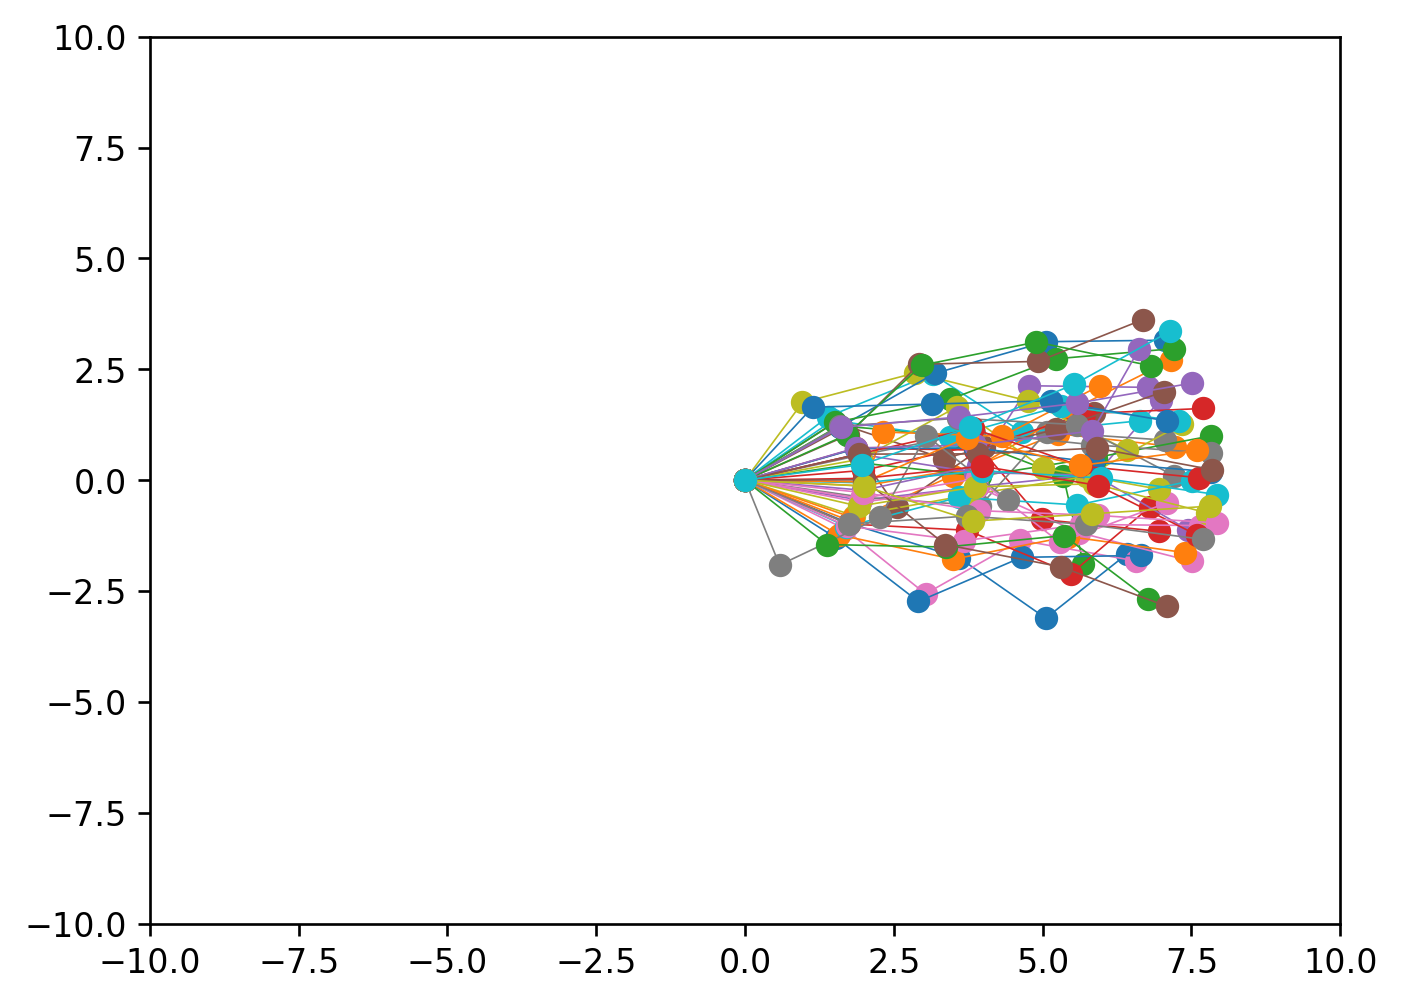

16


In [6]:
upp_lim = x_gt.shape[0]-101
ind=int(np.random.uniform(0, upp_lim))
print(ind)
x_coordinates, y_coordinates=coordinates(x_gt,p = parameters)
plt.figure(dpi = 240)
for i in range(ind,ind+50):
    plt.plot(x_coordinates[i,:],y_coordinates[i,:],'o',linestyle='-',linewidth='0.5')  

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.show()
data_gen={'x1':x_gt[:,0],'x2':x_gt[:,1],'x3':x_gt[:,2],'x4':x_gt[:,3],'y1':y_gt[0,:],'y2':y_gt[1,:],
         'xc_1':x_coordinates[:,0],'xc_2':x_coordinates[:,1],'xc_3':x_coordinates[:,2],'xc_4':x_coordinates[:,3],
         'xc_5':x_coordinates[:,4], 'yc_1':y_coordinates[:,0],'yc_2':y_coordinates[:,1],'yc_3':y_coordinates[:,2],
         'yc_4':y_coordinates[:,3],'yc_5':x_coordinates[:,4]}
print(len(data_gen))
df=pd.DataFrame(data_gen)
df.to_csv('INN_IK_data.csv',index=False)


In [7]:
for key, value in parameters.items():
    if isinstance(value, torch.Tensor):
        parameters[key] = value.to(device)


In [8]:
class loc_INN(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device=device
        self.num_blocks=6
        self.inn=self.inn_model()

        self.trainable_params=[p for p in self.inn.parameters() if p.requires_grad]
        if not self.trainable_params:
            print("No trainable paramters found..--> Exiting")
            raise SystemExit
        for param in self.trainable_params:
            param.data = 0.05 * torch.randn_like(param)

    def inn_model(self):
        
        def subnet_fc(cin,cout):
            return nn.Sequential(nn.Linear(cin,12),nn.ReLU(),nn.Linear(12,cout))

        nodes=[InputNode(int(num_inputs),name='input')]
        
        for k in range(self.num_blocks):
            nodes.append(Node(nodes[-1],GLOWCouplingBlock,{'subnet_constructor': subnet_fc,'clamp':2.0},conditions=None,name=F'coupling_{k}'))
            nodes.append(Node(nodes[-1],PermuteRandom,{'seed':k},name=F'permute_{k}'))

        nodes.append(OutputNode(nodes[-1],name='output'))
        return ReversibleGraphNet(nodes , verbose=False).to(self.device)

    def forward(self, x):
        return self.inn(x)
    
    def reverse(self, y_rev):
        return self.inn(y_rev, rev=True)

device="cpu"
loc_inn=loc_INN(device=device)
print(loc_inn)

loc_INN(
  (inn): ReversibleGraphNet(
    (module_list): ModuleList(
      (0): GLOWCouplingBlock(
        (subnet1): Sequential(
          (0): Linear(in_features=2, out_features=12, bias=True)
          (1): ReLU()
          (2): Linear(in_features=12, out_features=4, bias=True)
        )
        (subnet2): Sequential(
          (0): Linear(in_features=2, out_features=12, bias=True)
          (1): ReLU()
          (2): Linear(in_features=12, out_features=4, bias=True)
        )
      )
      (1): PermuteRandom()
      (2): GLOWCouplingBlock(
        (subnet1): Sequential(
          (0): Linear(in_features=2, out_features=12, bias=True)
          (1): ReLU()
          (2): Linear(in_features=12, out_features=4, bias=True)
        )
        (subnet2): Sequential(
          (0): Linear(in_features=2, out_features=12, bias=True)
          (1): ReLU()
          (2): Linear(in_features=12, out_features=4, bias=True)
        )
      )
      (3): PermuteRandom()
      (4): GLOWCouplingBlock(

### Data Loading

In [9]:
DATA=(pd.read_csv('INN_IK_data.csv')).values
DATA[:,:4]=DATA[:,:4]/parameters['x_lim']
parameters['y1_min']=min(DATA[:,4])
parameters['y1_max']=max(DATA[:,4])
parameters['y2_min']=min(DATA[:,5])
parameters['y2_max']=max(DATA[:,5])
DATA[:,4]=-1 + 2*((DATA[:,4]-parameters['y1_min'])/(parameters['y1_max']-parameters['y1_min']))
DATA[:,5]=-1 + 2*((DATA[:,5]-parameters['y2_min'])/(parameters['y2_max']-parameters['y2_min']))
print(parameters)

np.random.seed(42)
DATA_PERM=np.random.permutation(DATA)
train_ind=int(TEST_TRAIN_SPLIT*DATA_PERM.shape[0])
train_dataset=torch.tensor(DATA_PERM[0:train_ind,:])
test_dataset=torch.tensor(DATA_PERM[train_ind:,:])
df_train=pd.DataFrame(train_dataset)
df_train.to_csv("training_dataset.csv",index=False)
df_test=pd.DataFrame(test_dataset)
df_test.to_csv("testing_dataset.csv",index=False)

train_dataset,test_dataset=train_dataset.to(torch.float32),test_dataset.to(torch.float32)
train_dataset,test_dataset=train_dataset.to(device),test_dataset.to(device)

train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True,drop_last=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=True,drop_last=True)
print(train_dataset.shape)

{'l': 2.0, 'mu_all': 0, 's_all': 0.5, 'x_lim': 3.141592653589793, 'y1_min': np.float64(-6.653976187077789), 'y1_max': np.float64(6.687742397470431), 'y2_min': np.float64(2.828978229634173), 'y2_max': np.float64(7.997678403539945)}
torch.Size([70000, 16])


In [10]:
loc_inn=loc_INN(device)
loc_inn=loc_inn.to(torch.float32)
loc_inn=loc_inn.to(device)

MSE_loss=torch.nn.MSELoss().to(device) 
l1_loss=torch.nn.L1Loss().to(device)

optimizer = torch.optim.Adam(loc_inn.trainable_params, lr=current_lr)
scaler=GradScaler(enabled=mix_precision)
scheduler=ExponentialLR(optimizer,gamma=0.95)

C:\Users\Shobhnik\AppData\Local\Temp\ipykernel_9888\301745913.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler=GradScaler(enabled=mix_precision)


#### Bidirectional Training

In [11]:
loc_inn.train()
forward_loss=[]
reverse_loss=[]
for epoch in range(num_epochs):
    for batch_idx,data_x in enumerate(train_loader):
        optimizer.zero_grad() 
        with autocast(enabled=mix_precision):
            x_train=data_x[:,0:4]
            y_pred,_=loc_inn.forward(x_train)
            y_gt=data_x[:,4:6]
            z_sample=torch.randn((x_train.shape[0],2)).to(device)
            z_sample=z_sample.to(torch.float32)

            inn_recon_loss=MSE_loss(y_pred[:,0:2],y_gt)
            z_loss=MMD_matrix_multiscale(y_pred[:,2:4],z_sample,mmd_forw_kernels,device)
            
            tot_forward_loss=inn_recon_loss+z_loss
        scaler.scale(tot_forward_loss).backward(retain_graph=True)
        
        with autocast(enabled=mix_precision):
            y_train=data_x[:,4:6]
            samples = torch.randn((y_train.shape[0],2)).to(device)
            y_rev=torch.cat((y_train,samples),dim=1)
            y_rev2=torch.cat((y_train,y_pred[:,2:4]),dim=1)
            x_pred,_=loc_inn.reverse(y_rev)
            x_pred2,_=loc_inn.reverse(y_rev2)
            loss_rev_orig_z=MMD_matrix_multiscale(x_pred,x_train,mmd_back_kernels,device)
            tot_backward_loss=MSE_loss(x_pred2,x_train)+loss_rev_orig_z
        scaler.scale(tot_backward_loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(loc_inn.parameters(), 8)
        
        scaler.step(optimizer)
        scaler.update()
    forward_loss.append(tot_forward_loss.item())
    reverse_loss.append(tot_backward_loss.item())    
    print(f"Epoch [{epoch+1}/{num_epochs}], FLoss:{tot_forward_loss.item()}, RLoss:{tot_backward_loss.item()}, BLoss orig:{loss_rev_orig_z.item()}")

C:\Users\Shobhnik\AppData\Local\Temp\ipykernel_9888\2281434855.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=mix_precision):
C:\Users\Shobhnik\AppData\Local\Temp\ipykernel_9888\2281434855.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=mix_precision):


Epoch [1/15], FLoss:3.446730136871338, RLoss:0.9358444809913635, BLoss orig:0.9162509441375732
Epoch [2/15], FLoss:0.8521332740783691, RLoss:0.2961059808731079, BLoss orig:0.27675861120224
Epoch [3/15], FLoss:0.11470954120159149, RLoss:0.05052302032709122, BLoss orig:0.030183041468262672
Epoch [4/15], FLoss:0.07866041362285614, RLoss:0.03850986808538437, BLoss orig:0.01909901201725006
Epoch [5/15], FLoss:0.0743131935596466, RLoss:0.03937283903360367, BLoss orig:0.019999999552965164
Epoch [6/15], FLoss:0.079851433634758, RLoss:0.03574520722031593, BLoss orig:0.018252529203891754
Epoch [7/15], FLoss:0.06896555423736572, RLoss:0.03088531643152237, BLoss orig:0.016488956287503242
Epoch [8/15], FLoss:0.061741139739751816, RLoss:0.02784838154911995, BLoss orig:0.014512679539620876
Epoch [9/15], FLoss:0.06411983072757721, RLoss:0.03168729692697525, BLoss orig:0.018566077575087547
Epoch [10/15], FLoss:0.05680987983942032, RLoss:0.024554003030061722, BLoss orig:0.011888126842677593
Epoch [11/15

Text(0, 0.5, 'Loses')

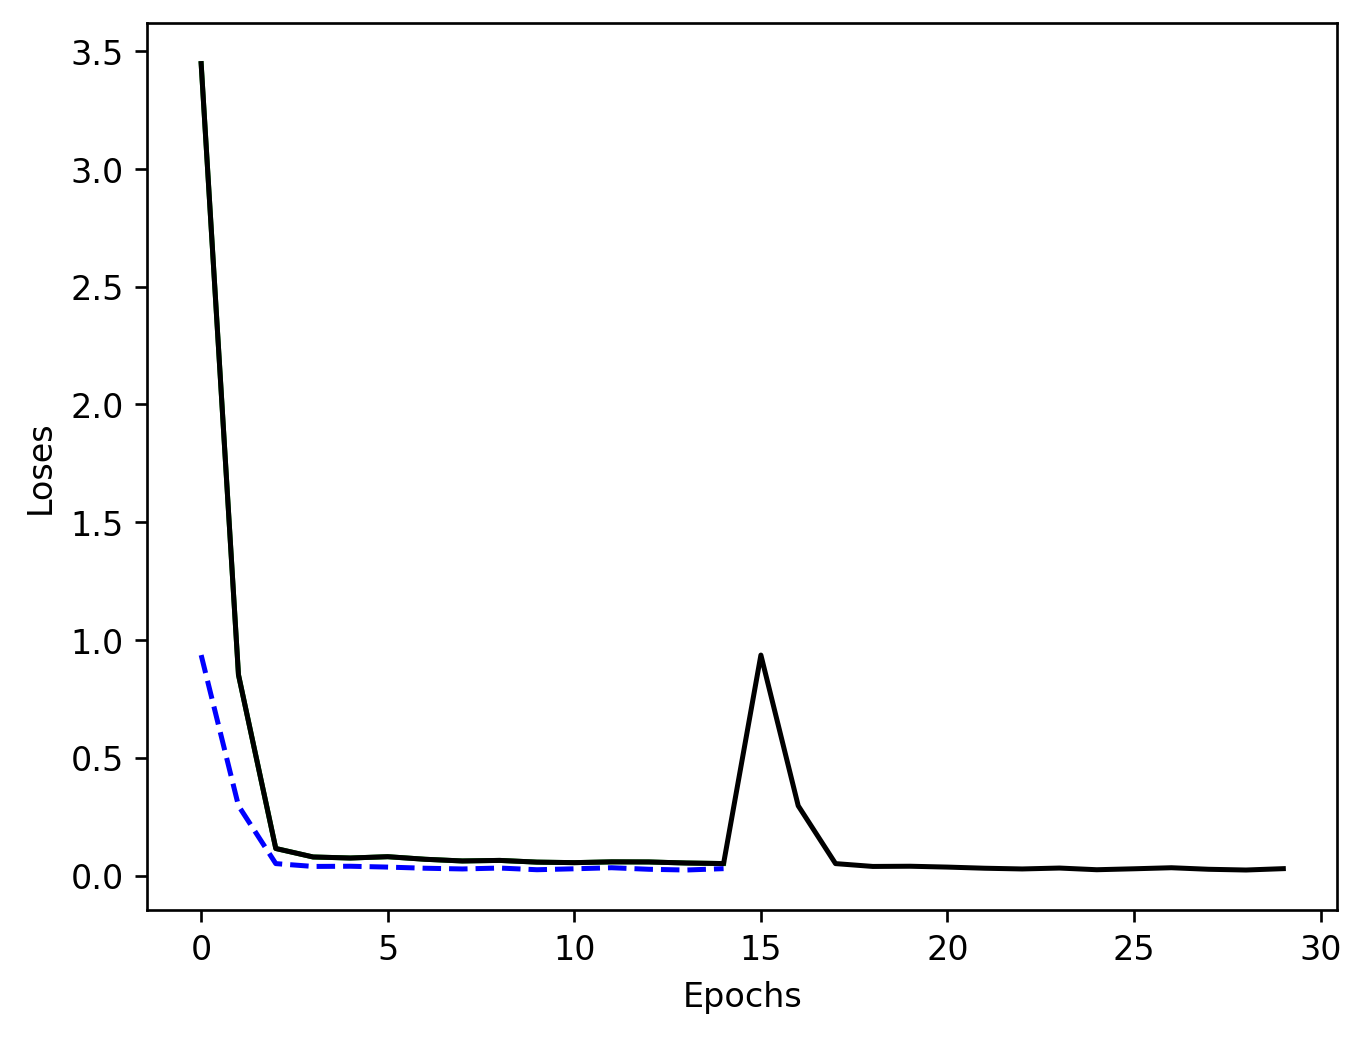

In [12]:
plt.figure(dpi=240)
plt.plot(forward_loss,'-g')
plt.plot(reverse_loss,'--b')
plt.plot(forward_loss+reverse_loss,'-k')
plt.xlabel('Epochs')
plt.ylabel("Loses")

In [13]:
save_model=0
if save_model==True:
    model_name=input('Enter the model_name as name.pth \n')
    torch.save(loc_inn, models + model_name)

58192
[[ 0.04067527 -1.0872945  -0.9224599  -0.03154341]]


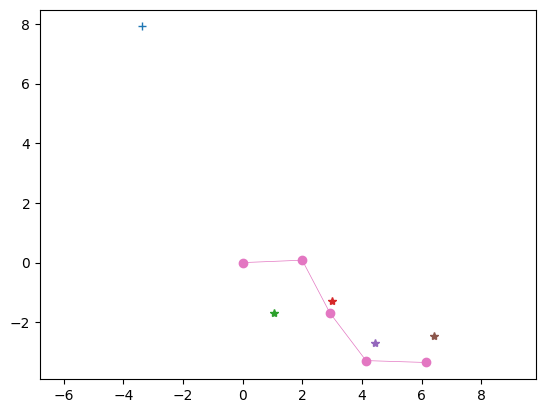

In [14]:
loc_inn.train(False)
with torch.no_grad():
    ind = int(np.random.uniform(0, train_dataset.shape[0]))
    print(ind)
    plt.figure()
    
    x_sample = torch.tensor(DATA[ind:ind+1, 0:4], dtype=torch.float32).to(device)
    y1y2, _ = loc_inn.forward(x_sample)
    y1y2 = y1y2.cpu().detach().numpy()
    
    y1y2_denorm = y1y2.copy()
    y1y2_denorm[0, 1] = (parameters['y2_max'] - parameters['y2_min']) * (y1y2[0, 1] + 1) * 0.5 + parameters['y2_min']
    y1y2_denorm[0, 0] = (parameters['y1_max'] - parameters['y1_min']) * (y1y2[0, 0] + 1) * 0.5 + parameters['y1_min']
    plt.plot(y1y2_denorm[0, 0], y1y2_denorm[0, 1], '+')
    
    samples = torch.randn((1, 2)).to(device)
    y_rev = torch.cat((torch.tensor(DATA[ind:ind+1, 4:6], dtype=torch.float32).to(device), samples), dim=1)
    
    x1x4, _ = loc_inn.reverse(y_rev)
    x1x4 = x1x4.cpu().detach().numpy()
    x1x4[:, 0] = x1x4[:, 0] * parameters['x_lim']
    x1x4[:, 1:4] = x1x4[:, 1:4] * parameters['x_lim']
    
    x_c, y_c = coordinates(x1x4, parameters)
    plt.plot(x_coordinates[ind:ind+1, :], y_coordinates[ind:ind+1, :], '*', linestyle='-', linewidth='0.5')
    plt.plot(x_c[0, :], y_c[0, :], 'o', linestyle='-', linewidth='0.5')
    plt.axis('equal')
    print(x1x4)

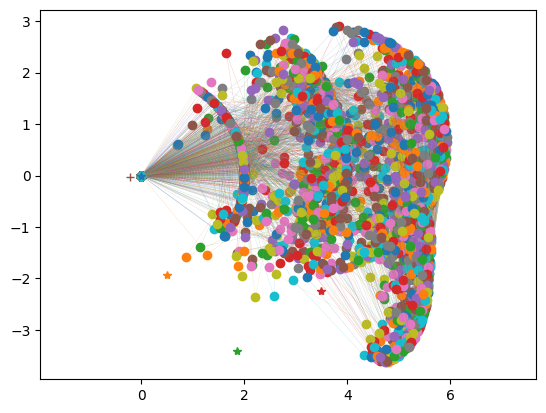

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def coordinates1(x, p=parameters):
    """
    Calculates the coordinates of points in the manipulator's workspace.

    Args:
        x: Input angles (num_samples, num_links)
        p: Parameters dictionary (containing link length 'l', etc.)

    Returns:
        x_c: x-coordinates of points (num_samples, num_links+1)
        y_c: y-coordinates of points (num_samples, num_links+1)
    """
    x_c = np.zeros((x.shape[0], x.shape[1] + 1))
    y_c = np.zeros((x.shape[0], x.shape[1] + 1))

    for i in range(1, x.shape[1] + 1):
        y_c[:, i] = np.sum(p["l"] * np.sin(x[:, :i]), axis=1)
        x_c[:, i] = np.sum(p["l"] * np.cos(x[:, :i]), axis=1)

    return x_c, y_c

ind = int(np.random.uniform(0, train_dataset.shape[0]))

tens = torch.tensor(DATA[ind:ind + 1, 4:6]).to(device)

num_rev_samples = 800
samples = torch.randn((num_rev_samples, 2)).to(device)

y_rev = torch.cat((tens.expand_as(samples), samples), dim=1)

x1x4, _ = loc_inn.reverse(y_rev.float())
x1x4 = x1x4.cpu().detach().numpy()

x1x4[:, 0] = x1x4[:, 0] * parameters['x_lim']
x1x4[:, 1:4] = x1x4[:, 1:4] * parameters['x_lim']

x_c, y_c = coordinates1(x1x4, parameters)

plt.figure()
for i in range(x_c.shape[0]):
    plt.plot(x_c[i, :], y_c[i, :], 'o', linestyle='--', linewidth=0.1)

plt.plot(x_coordinates[ind:ind + 1, :], y_coordinates[ind:ind + 1, :], '*', linestyle='-', linewidth=0.5)

plt.plot(DATA[ind:ind + 1, 4], DATA[ind:ind + 1, 5], '+')

plt.axis('equal')
plt.show()

In [16]:
# plt.plot(y1y2_denorm[:,0],y1y2[:,1],'+')

#### Testing

In [17]:
loc_inn.train(False)
for_err=[]
rev_err=[]
y_pred_store=[]
x_pred_store=[]
with torch.no_grad():
    for batch_idx,data_x in enumerate(test_loader):
      
        with autocast(enabled=mix_precision):
            x_test=data_x[:,0:4]
            x_test.to(device)
            y_pred,_=loc_inn.forward(x_train)
            y_pred_store.append(y_pred)
            y_truth=data_x[:,4:6]
            inn_recon_loss=l1_loss(y_pred[:,0:2],y_truth)
            tot_forward_loss=inn_recon_loss
            yp_err=y_pred[:,0:2]
            yp_err[:,1]=(parameters['y2_max']-parameters['y2_min'])*(y_pred[:,1]+1)*0.5 +parameters['y2_min']
            yp_err[:,0]=(parameters['y1_max']-parameters['y1_min'])*(y_pred[:,0]+1)*0.5 +parameters['y1_min']
            yt_err=y_truth
            yt_err[:,1]=(parameters['y2_max']-parameters['y2_min'])*(y_truth[:,1]+1)*0.5 +parameters['y2_min']
            yt_err[:,0]=(parameters['y1_max']-parameters['y1_min'])*(y_truth[:,0]+1)*0.5 +parameters['y1_min']
            
            err=torch.norm(yp_err-yt_err)/x_test.shape[0]

            samples = torch.randn((y_truth.shape[0],2)).to(device)
            
            y_for_back=torch.cat((y_truth,samples),dim=1)
            x_pred,_=loc_inn.reverse(y_for_back)
            x_pred[:,:4]=x_pred[:,:4]*parameters['x_lim']
            x_pred_store.append(x_pred)
            x_test[:,:4]=x_test[:,:4]*parameters['x_lim']            
            rev_error=torch.median(torch.norm(x_pred-x_test),dim=0).values/x_test.shape[0]
            
            print(f"Batch [{batch_idx+1}],F Error:{err.item()},R Error:{rev_error}")

C:\Users\Shobhnik\AppData\Local\Temp\ipykernel_9888\3603551808.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=mix_precision):


Batch [1],F Error:0.06018204987049103,R Error:0.5863305330276489
Batch [2],F Error:0.061155010014772415,R Error:0.5834527611732483
Batch [3],F Error:0.0616183802485466,R Error:0.6030665040016174
Batch [4],F Error:0.059618979692459106,R Error:0.5900465250015259
Batch [5],F Error:0.06118333339691162,R Error:0.5910018682479858
Batch [6],F Error:0.06073529273271561,R Error:0.5845018625259399
Batch [7],F Error:0.0593024380505085,R Error:0.5857409238815308
Batch [8],F Error:0.0599970780313015,R Error:0.590839684009552
Batch [9],F Error:0.05974900722503662,R Error:0.5866710543632507
Batch [10],F Error:0.060014400631189346,R Error:0.5749344825744629
Batch [11],F Error:0.059747446328401566,R Error:0.5827329158782959
Batch [12],F Error:0.06132759526371956,R Error:0.5844354033470154
Batch [13],F Error:0.058565784245729446,R Error:0.5859360694885254
Batch [14],F Error:0.059583328664302826,R Error:0.580470621585846
Batch [15],F Error:0.06067148968577385,R Error:0.5882351398468018


##### Reversing the model with n samples of z drawn from normal distribution and then calculating the x and then plot the mechanism

In [18]:
# loc_inn.eval()
# for_err=[]
# rev_err=[]
# y_pred_store=[]
# x_pred_store=[]
# n_z_samples=100
# with torch.no_grad():
#     with autocast(enabled=mix_precision):
#         data=test_loader.dataset
#         print(data.shape)
#         # print(y_pred)
#         rand_ind=200
#         y_truth=data[rand_ind,4:6]
#         y_repeated_tensor = y_truth.unsqueeze(0).repeat(n_z_samples, 1)
    
#         # The reverse process we need to have n samples of z attached to y ground truth and calculate x
#         samples = torch.randn((y_repeated_tensor.shape[0],2)).to(device)
#         # print(y_repeated_tensor)
#         y_for_back=torch.cat((y_repeated_tensor,samples),dim=1)
#         print(y_for_back.shape)
#         x_pred,_=loc_inn.reverse(y_for_back)
#         # x_pred_store.append(x_pred)
#         rev_error=torch.median(torch.norm(x_pred-data[rand_ind,0:4]),dim=0)
#     x_pred=(torch.detach(x_pred)).numpy()
#     x_truth=(torch.detach(data[rand_ind,:])).numpy()



In [19]:
loc_inn.eval()
with torch.no_grad():
    with autocast(enabled=mix_precision):
        data=test_loader.dataset
        rand_ind = 90
        y_truth=data[rand_ind,4:6]
        print(y_truth)
        print(y_truth.size())
        y_rep_ten=y_truth.unsqueeze(0)
        print(y_rep_ten.size(), ": Shape of the y rep tensor")
        samples = torch.randn((y_rep_ten.shape[0],2)).to(device)
        y_for_back = torch.cat((y_rep_ten,samples),dim=1)
        print(y_for_back, ": Combined y and z as tensor")
        print(y_for_back.shape, ": Shape of the final tensor")
        x_pred = loc_inn.reverse(y_for_back)
    x_pred=torch.detach(x_pred[0]).numpy()
    re_x_pred=np.reshape(x_pred,(4,))
    y_rep_np = torch.detach(y_rep_ten).numpy()
    y_rep_final = np.reshape(y_rep_np,(2,))
    print(y_rep_final, ": The final array of the end effector position")
    print(re_x_pred, ": The final array for the predicted x values")

tensor([-0.3594,  0.7231])
torch.Size([2])
torch.Size([1, 2]) : Shape of the y rep tensor
tensor([[-0.3594,  0.7231,  0.8113,  1.0024]]) : Combined y and z as tensor
torch.Size([1, 4]) : Shape of the final tensor
[-0.3594079  0.7231476] : The final array of the end effector position
[-0.28567964  0.15214883  0.14896476 -0.06569624] : The final array for the predicted x values


C:\Users\Shobhnik\AppData\Local\Temp\ipykernel_9888\1488014270.py:3: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=mix_precision):


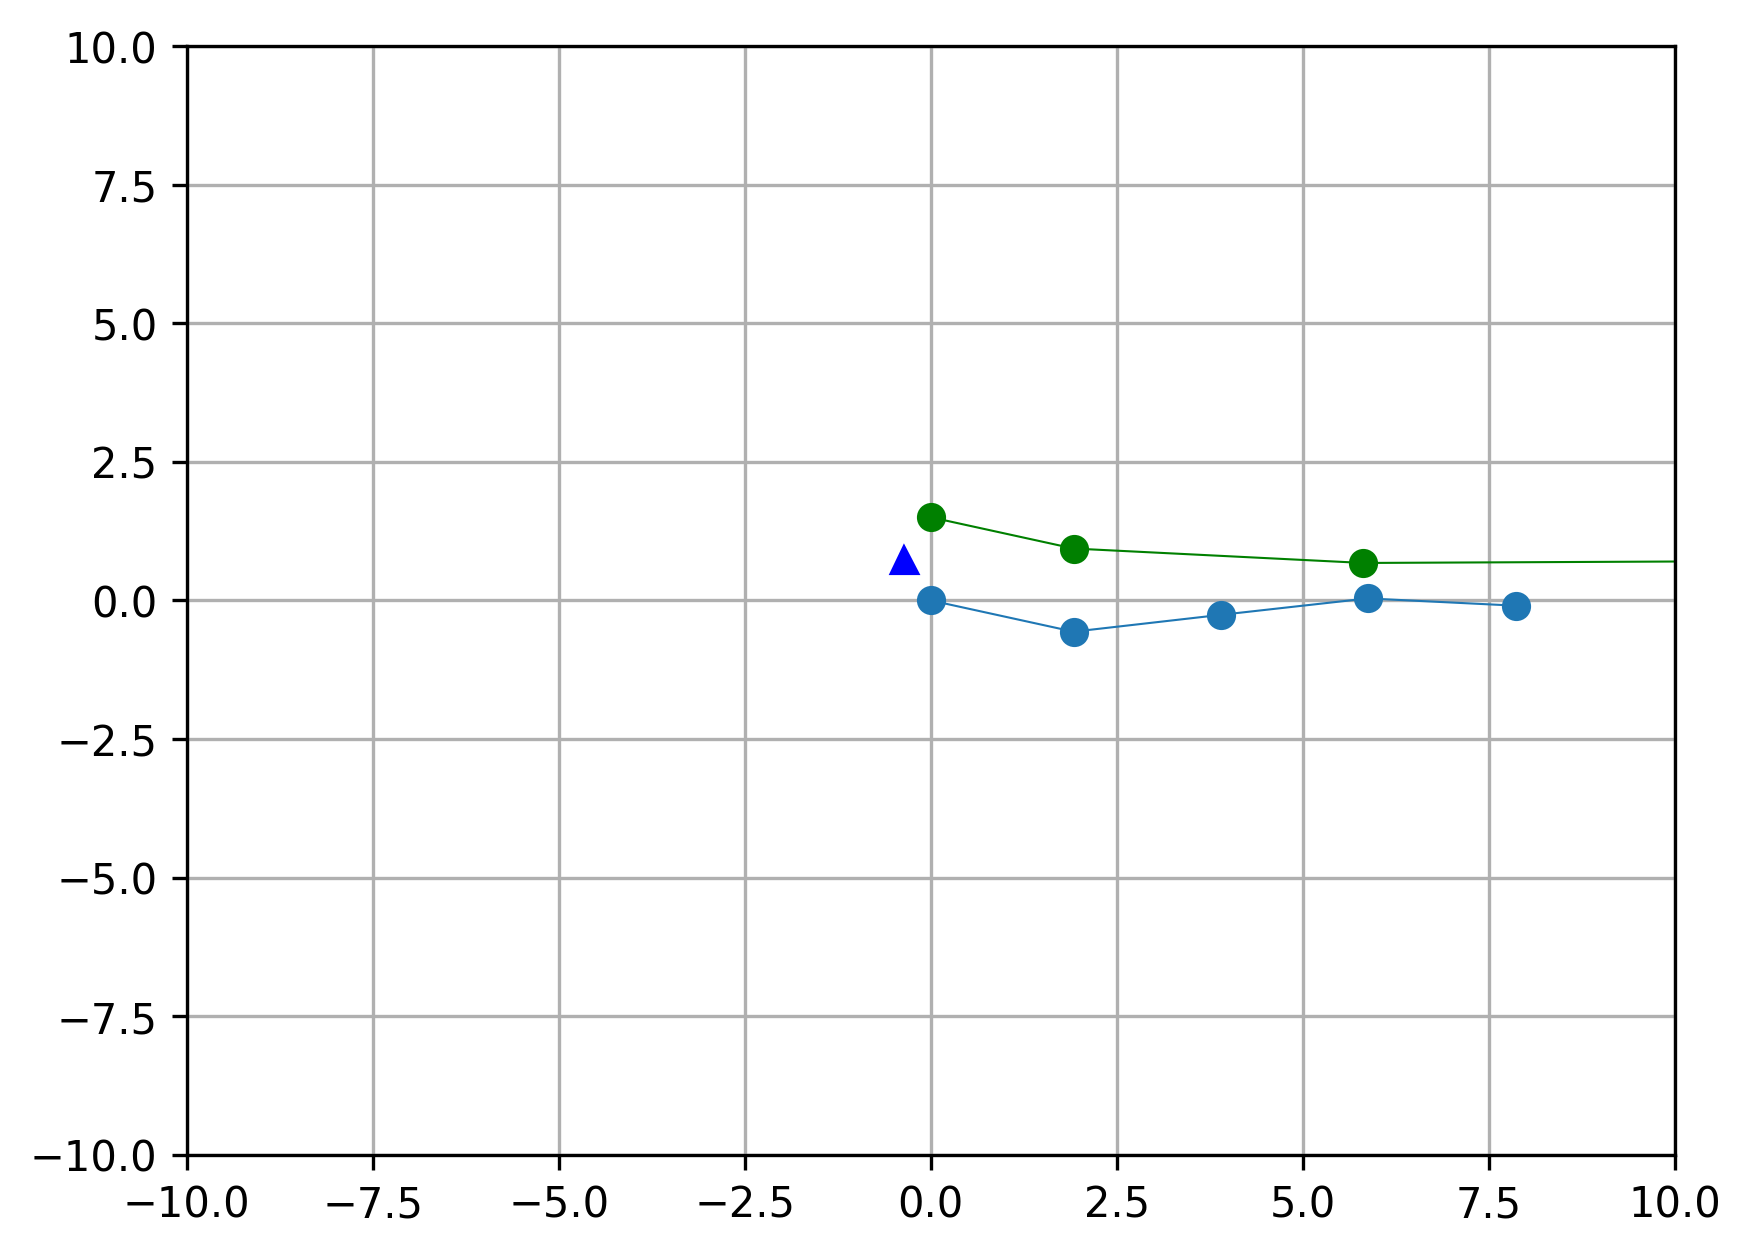

In [20]:
y_pc=np.zeros((5,))
x_pc=np.zeros((5,))
y_pc[1] = parameters["l"]*np.sin(re_x_pred[0])
y_pc[2] = parameters["l"]*np.sin(re_x_pred[0]) + parameters["l"]*np.sin(re_x_pred[1])
y_pc[3] = parameters["l"]*np.sin(re_x_pred[0]) + parameters["l"]*np.sin(re_x_pred[1]) + parameters["l"]*np.sin(re_x_pred[2])
y_pc[4] = parameters["l"]*np.sin(re_x_pred[0]) + parameters["l"]*np.sin(re_x_pred[1]) + parameters["l"]*np.sin(re_x_pred[2]) + parameters["l"]*np.sin(re_x_pred[3])
    
x_pc[1] = parameters["l"]*np.cos(re_x_pred[0])
x_pc[2] = parameters["l"]*np.cos(re_x_pred[0]) + parameters["l"]*np.cos(re_x_pred[1])
x_pc[3] = parameters["l"]*np.cos(re_x_pred[0]) + parameters["l"]*np.cos(re_x_pred[1]) + parameters["l"]*np.cos(re_x_pred[2])
x_pc[4] = parameters["l"]*np.cos(re_x_pred[0]) + parameters["l"]*np.cos(re_x_pred[1]) + parameters["l"]*np.cos(re_x_pred[2]) + parameters["l"]*np.cos(re_x_pred[3])

links=4
fixed = np.array([0,1.5])
lengths=np.full((4,),parameters["l"])

points = np.zeros((links+1,2))
points[0] = fixed
for i in range(1,links+1):
    points[i] = points[i-1] + np.array([x_pc[i],y_pc[i]])

plt.figure(dpi=300)
plt.plot(x_pc[:], y_pc[:],'o',linestyle='-',linewidth='0.5')

plt.plot(points[:,0],points[:,1],marker="o",color="g",linewidth="0.5")
plt.plot(y_rep_final[0],y_rep_final[1],marker="^",color="b")
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.grid()
plt.show()
